# Stochastic Optimal Control & Reinforcment Learning : Part VI

In [1]:
import numpy as np
import model
import lstd
import utils
from scipy.stats import multivariate_normal
from scipy.optimize import minimize
import matplotlib.pyplot as plt

In [2]:
SOURCE = "./results/"

## Prerequesite

We define a function to compute the value function of the LQR policy 

In [3]:
def ricatti_recursion(A, B, Q, R, S, P0, eps = 1e-6, max_iter = 1000):

    Pnew = P0
    Pold = P0
    for _ in range(max_iter):
        Pnew = Q + A.T @ Pold @ A - (A.T @ Pold @ B + S).T @ np.linalg.inv(R + B.T @ Pold @ B) @ (A.T @ Pold @ B + S)
        if np.linalg.norm(Pnew - Pold) < eps:
            print("Converged")
            break
        Pold = Pnew

    return Pnew

P = ricatti_recursion(model.A, model.B, model.Q, model.R, model.S, np.eye(5))

def V_functionLQR(x):
    return x.T @ P @ x


Converged


## 7. Mean Square Belman Error

### 2. Estimation of MSBE linear system

We implement the subroutine to compute the conditional expectation

In [4]:
def cond_expect(phi : callable, psi_Q : callable, next_states_probs : list) -> np.ndarray:
    """
    Computes the conditional expectation E_{x'} [psi_Q(x', phi(x')) | x, u]
    when the transition kernel has finite support.

    Parameters:
    - phi: Policy function, phi(x') returns action at state x'.
    - psi_Q: Function that computes the feature vector psi_Q(x', u').
    - next_states_probs: List of tuples (x'_i, p_i), where x'_i is a possible next state
                         and p_i is the probability of transitioning to x'_i from (x, u).

    Returns:
    - expectation: The computed conditional expectation as a feature vector.
    """

    expectation = 0
    for x_prime, p in next_states_probs:
        u_prime = phi(x_prime)
        psi_value = psi_Q(x_prime, u_prime)
        expectation += p * psi_value
    return expectation

In [5]:
def compute_next_states_probs(x : np.ndarray, u : np.ndarray, transition_kernel : list, model_str : str = "lin") -> list:
    """
    Computes the list of next states and their probabilities given the current state and action.
    
    Parameters:
    - x: The current state.
    - u: The current action.
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the transition noise and p_i is the probability of transitioning to x + w_i.
    
    Returns:
    - next_states_probs: List of tuples (x'_i, p_i), where x'_i is a possible next state
                         and p_i is the probability of transitioning to x'_i from (x, u).
    """

    next_states_probs = []
    for w_i, p_i in transition_kernel:
        if model_str == "lin":
            x_prime = model.linear_step(x, u, w_i)
        elif model_str == "nonlin":
            x_prime = model.non_linear_step(x, u, w_i)
        else:
            raise ValueError("Invalid model type. Must be 'lin' or 'nonlin'.")

        next_states_probs.append((x_prime, p_i))
    
    return next_states_probs

and the function to compute the MSBE

In [57]:
def compute_MSBE(data, transition_kernel, psi_Q_func, psi_eta_vect, model_str = "lin", policy : callable = model.LQR_policy, treshold_iter : int = 0):
    """
    Computes the Mean-Squared Bellman Error (MSBE) for a given dataset and policy.

    Parameters:
    - data: List of tuples (x, u, r, x_prime).
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the transition noise and p_i is the probability of transitioning to x + w_i.
    - psi_Q_func: Function that computes the feature vector psi_Q(x, u).
    - psi_eta_vect: Feature vector for the reward function.
    - model_str: String indicating the model type. Must be 'lin' or 'nonlin'.

    Returns:
    - MSBE: The computed MSBE.
    """

    n_step = len(data[1])
    theta_dim = len(psi_eta_vect)

    A = np.zeros((theta_dim, theta_dim))
    b = np.zeros(theta_dim)

    for i, (x_i, u_i) in enumerate(zip(data[0].T, data[1].T)):

        if i < treshold_iter:
            continue

        next_states_probs = compute_next_states_probs(x_i, u_i, transition_kernel, model_str=model_str)
        cond_expectation  = cond_expect(policy, psi_Q_func, next_states_probs)

        psi_Q_i = psi_Q_func(x_i, u_i)
        c_i = model.cost(x_i, u_i)

        f_i = cond_expectation - psi_Q_i - psi_eta_vect

        A += np.outer(f_i, f_i)
        b -= f_i * c_i

    A /= n_step
    b /= n_step

    A += np.eye(theta_dim) * 1e-12  # Regularization

    # Solve the linear system
    theta_MSBE = np.linalg.solve(A, b)
    return theta_MSBE


def policy_improvement_MSBE(initial_policy, psi_func, psi_eta_vect, transition_kernel, data, model_str = "lin", max_iter = 100, treshold_iter = 0):
    """
    Computes the policy improvement step using the MSBE objective.

    Parameters:
    - theta: The current parameter vector.
    - psi_Q_func: Function that computes the feature vector psi_Q(x, u).
    - psi_eta_vect: Feature vector for the reward function.
    - model_str: String indicating the model type. Must be 'lin' or 'nonlin'.

    Returns:
    - theta_new: The updated parameter vector.
    """

    theta_MSBE = None
    policy = initial_policy

    def improved_policy(x, theta):
        sum = theta[4]*x[0] + theta[5]*x[3] + theta[6]*x[4]
        return - sum / (2*theta[3])

    for iter in range(max_iter):
        theta_MSBE = compute_MSBE(data, transition_kernel, psi_func, psi_eta_vect, model_str=model_str, policy=policy, treshold_iter=treshold_iter)
        policy = lambda x: improved_policy(x, theta = theta_MSBE)

    return theta_MSBE

### 3. Implementation of MSBE linear system

We define a function to generate a transition kernel with finite support

In [7]:
def generate_finite_kernel(n_noises: int, noise_std: float, k: int = 2) -> list:
    """
    Generates a finite transition kernel for a 2D Gaussian noise model.

    Parameters:
    - n_noises: Number of noise values per dimension (total will be n_noises^2).
    - noise_std: Standard deviation of the noise (same for both dimensions).
    - k: Defines the range of the noise as [-k * noise_std, k * noise_std].

    Returns:
    - transition_kernel: List of tuples (w_i, p_i) where w_i is the 2D noise vector,
      and p_i is the joint probability of transitioning to x + w_i.
    """
    # Define the range of noise values for each dimension
    x_min = -k * noise_std
    x_max = k * noise_std
    
    # Generate a grid of noise values for both dimensions
    noise_values_1d = np.linspace(x_min, x_max, n_noises, endpoint=True)
    grid_x, grid_y = np.meshgrid(noise_values_1d, noise_values_1d)
    dx, dy = grid_x[0, 1] - grid_x[0, 0], grid_y[1, 0] - grid_y[0, 0]
    noise_vectors = np.column_stack([grid_x.ravel(), grid_y.ravel()])  # Shape: (n_noises^2, 2)
    
    # Define the 2D Gaussian distribution
    mean = np.zeros(2)
    cov = np.diag([noise_std**2, noise_std**2])
    mvn = multivariate_normal(mean=mean, cov=cov)
    
    # Compute probabilities for each noise vector
    probabilities = mvn.pdf(noise_vectors) * dx * dy  # Multiply by the grid cell area
    probabilities /= np.sum(probabilities)  # Normalize to sum to 1
    
    # Return the noise vectors and their probabilities
    return list(zip(noise_vectors, probabilities))

We know define the exploration policy which is a baseline policy perturbed by noise to explore

In [8]:
def phi_e(x : np.ndarray, exploration_std : float, baseline_policy : callable = model.LQR_policy) -> np.ndarray:

    """
    Generates an exploratory action using a Gaussian distribution with standard deviation exploration_std around a baseline policy.
    
    Parameters:
    - x: The state.
    - exploration_std: Standard deviation of the Gaussian distribution.
    - baseline_policy: The baseline policy function, baseline_policy(x) returns the action at state x.
    
    Returns:
    - u: The generated action.
    """
    exploration_noise = np.random.normal(0, exploration_std)
    u = baseline_policy(x) + exploration_noise

    return u

## a. Linear Model : Approximation of LQR Q-function

We define $\psi_Q$ and $\psi_\eta$

In [9]:
def psi_Q(x, u):

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

def policy_Q(x, theta):
    sum = theta[4]*x[0] + theta[5]*x[3] + theta[6]*x[4]
    return - sum / (2*theta[3])
    
psi_eta = np.ones(10)

We first investigate the impact of the process noise 

In [10]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 1000
exploration_std = 1e-2
M = 10 


n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]
V_function_noises = {}

for noise_std in noises_std:

    V_lqr_train, V_lqr_test, V_msbe_train, V_msbe_test = [] , [] , [] , []

    for _ in range(M):
        # Simulate data

        policy_explo = lambda x: phi_e(x, exploration_std=exploration_std)
        data_train = model.simulate_linear_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)
        data_lqr_test = model.simulate_linear_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE

        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin", treshold_iter=200)
        Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)

        V_lqr_train.append(np.array([V_functionLQR(x) for x in data_train[0][:, :-1].T]).squeeze())
        V_lqr_test.append(np.array([V_functionLQR(x) for x in data_lqr_test[0][:, :-1].T]).squeeze())

        V_msbe_train.append(np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze())
        V_msbe_test.append(np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze())



    V_function_noises[noise_std] = {
            "V_noise_train" : np.mean(V_lqr_train, axis = 0),
            "V_noise_test" : np.mean(V_lqr_test, axis = 0),
            "V_MSBE_train" : np.mean(V_msbe_train, axis = 0),
            "V_MSBE_test" : np.mean(V_msbe_test, axis = 0)
        }


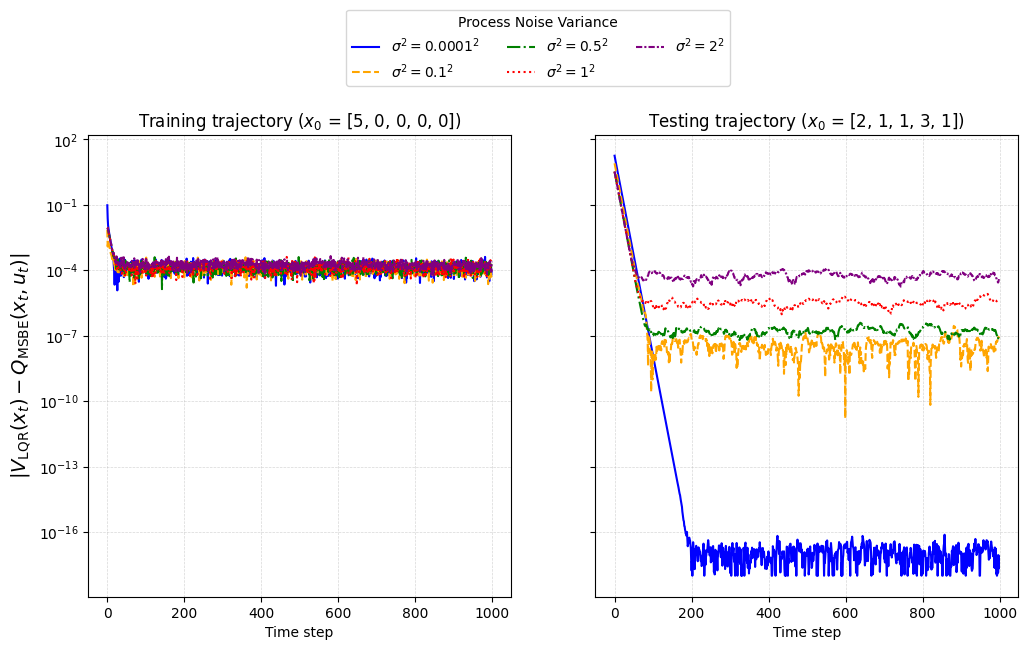

In [11]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, V_function_noise), linestyle, color in zip(V_function_noises.items(), linestyles, colors):
    ax1.semilogy(np.clip(np.abs(V_function_noise["V_noise_train"] - V_function_noise["V_MSBE_train"]), 1e-18, None), label=fr"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)
    ax2.semilogy(np.clip(np.abs(V_function_noise["V_noise_test"] - V_function_noise["V_MSBE_test"]), 1e-18, None), label=f"$\sigma^2 = {noise_std}^2$", linestyle=linestyle, color=color)

handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title = "Process Noise Variance")

ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

ax2.set_title(rf"Testing trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 

plt.savefig(SOURCE + "/linear_noise_std.pdf", dpi = 300, bbox_inches='tight')
plt.show()



We now investigate the impact of the exploration policy std

In [12]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 1000
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 1e-2

V_function_explo = {}
noises_explo = [0.0, 1e-3, 0.1, 1.0, 2]

for noise_explo in noises_explo:
    V_lqr_train_vals, V_lqr_test_vals, V_msbe_train_vals, V_msbe_test_vals = [], [], [], []

    for _ in range(M):  # Perform M simulations

        # Simulate data
        data_lqr_test = model.simulate_linear_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const = noise_std)
        policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)
        data_train = model.simulate_linear_model(x0_train, policy_explo, n_step, std_const = noise_std, with_noise=True)

        # Compute MSBE
        
        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin", treshold_iter=200)
        Q_MSBE = lambda x, u: model.Q_function(x, u, theta=theta_MSBE, psi_func=psi_Q)

        V_lqr_train = np.array([V_functionLQR(x) for x in data_train[0].T]).squeeze()
        V_lqr_test = np.array([V_functionLQR(x) for x in data_lqr_test[0].T]).squeeze()

        V_msbe_train = np.array([Q_MSBE(x, u) for x, u in zip(data_train[0].T, data_train[1].T)]).squeeze()
        V_msbe_test = np.array([Q_MSBE(x, u) for x, u in zip(data_lqr_test[0].T, data_lqr_test[1].T)]).squeeze()

        V_lqr_train_vals.append(V_lqr_train)
        V_lqr_test_vals.append(V_lqr_test)
        V_msbe_train_vals.append(V_msbe_train)
        V_msbe_test_vals.append(V_msbe_test)

    # Compute mean and std for each metric
    V_function_explo[noise_explo] = {
        "V_lqr_train_mean": np.mean(V_lqr_train_vals, axis=0),
        "V_lqr_test_mean": np.mean(V_lqr_test_vals, axis=0),
        "V_msbe_train_mean": np.mean(V_msbe_train_vals, axis=0),
        "V_msbe_test_mean": np.mean(V_msbe_test_vals, axis=0),
        
    }


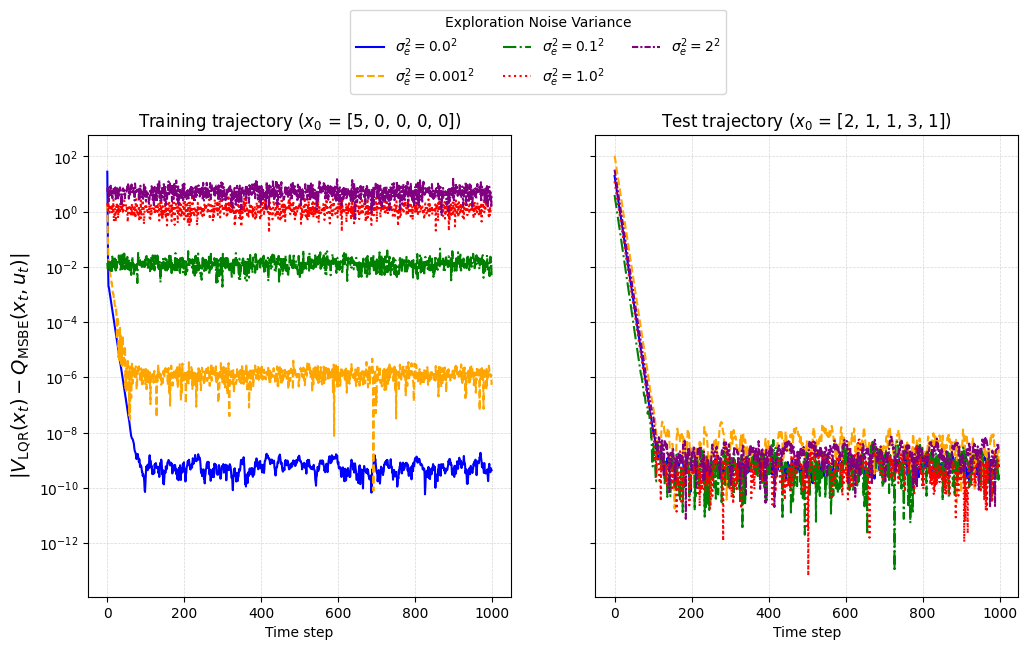

In [13]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]
colors = ['blue', 'orange', 'green', 'red', 'purple', 'brown']

for (noise_std, stats), linestyle, color in zip(V_function_explo.items(), linestyles, colors):
    train_error_mean = np.abs(stats["V_lqr_train_mean"][:-1] - stats["V_msbe_train_mean"])
    test_error_mean = np.abs(stats["V_lqr_test_mean"][:-1] - stats["V_msbe_test_mean"])


    time_steps = np.arange(len(train_error_mean))


    ax1.semilogy(
        np.clip(train_error_mean, 1e-18, None),
        label=fr"$\sigma_e^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

    ax2.semilogy(
        np.clip(test_error_mean, 1e-18, None),
        label=fr"$\sigma_e^2 = {noise_std}^2$",
        linestyle=linestyle,
        color=color,
    )

# Add shared legend
handles, labels = ax1.get_legend_handles_labels()
by_label = dict(zip(labels, handles))
fig.legend(by_label.values(), by_label.keys(), loc='upper center', ncol=3, bbox_to_anchor=(0.5, 1.1), title="Exploration Noise Variance")

# Customize the subplots
ax1.set_title(rf"Training trajectory ($x_0$ = {x0_train})")
ax1.set_xlabel("Time step")
ax1.set_ylabel(r"$|V_{\text{LQR}}(x_t) - Q_{\text{MSBE}}(x_t, u_t)|$", fontsize=14)
ax1.grid(True, linestyle='--', linewidth=0.5, alpha=0.5)

ax2.set_title(rf"Test trajectory ($x_0$ = {x0_test})")
ax2.set_xlabel("Time step")
ax2.grid(True,linestyle='--', linewidth=0.5, alpha=0.5) 
plt.savefig(SOURCE + "/linear_exploration_std.pdf", dpi = 300, bbox_inches='tight')
plt.show()

We display an example of trajectory from the exploration policy

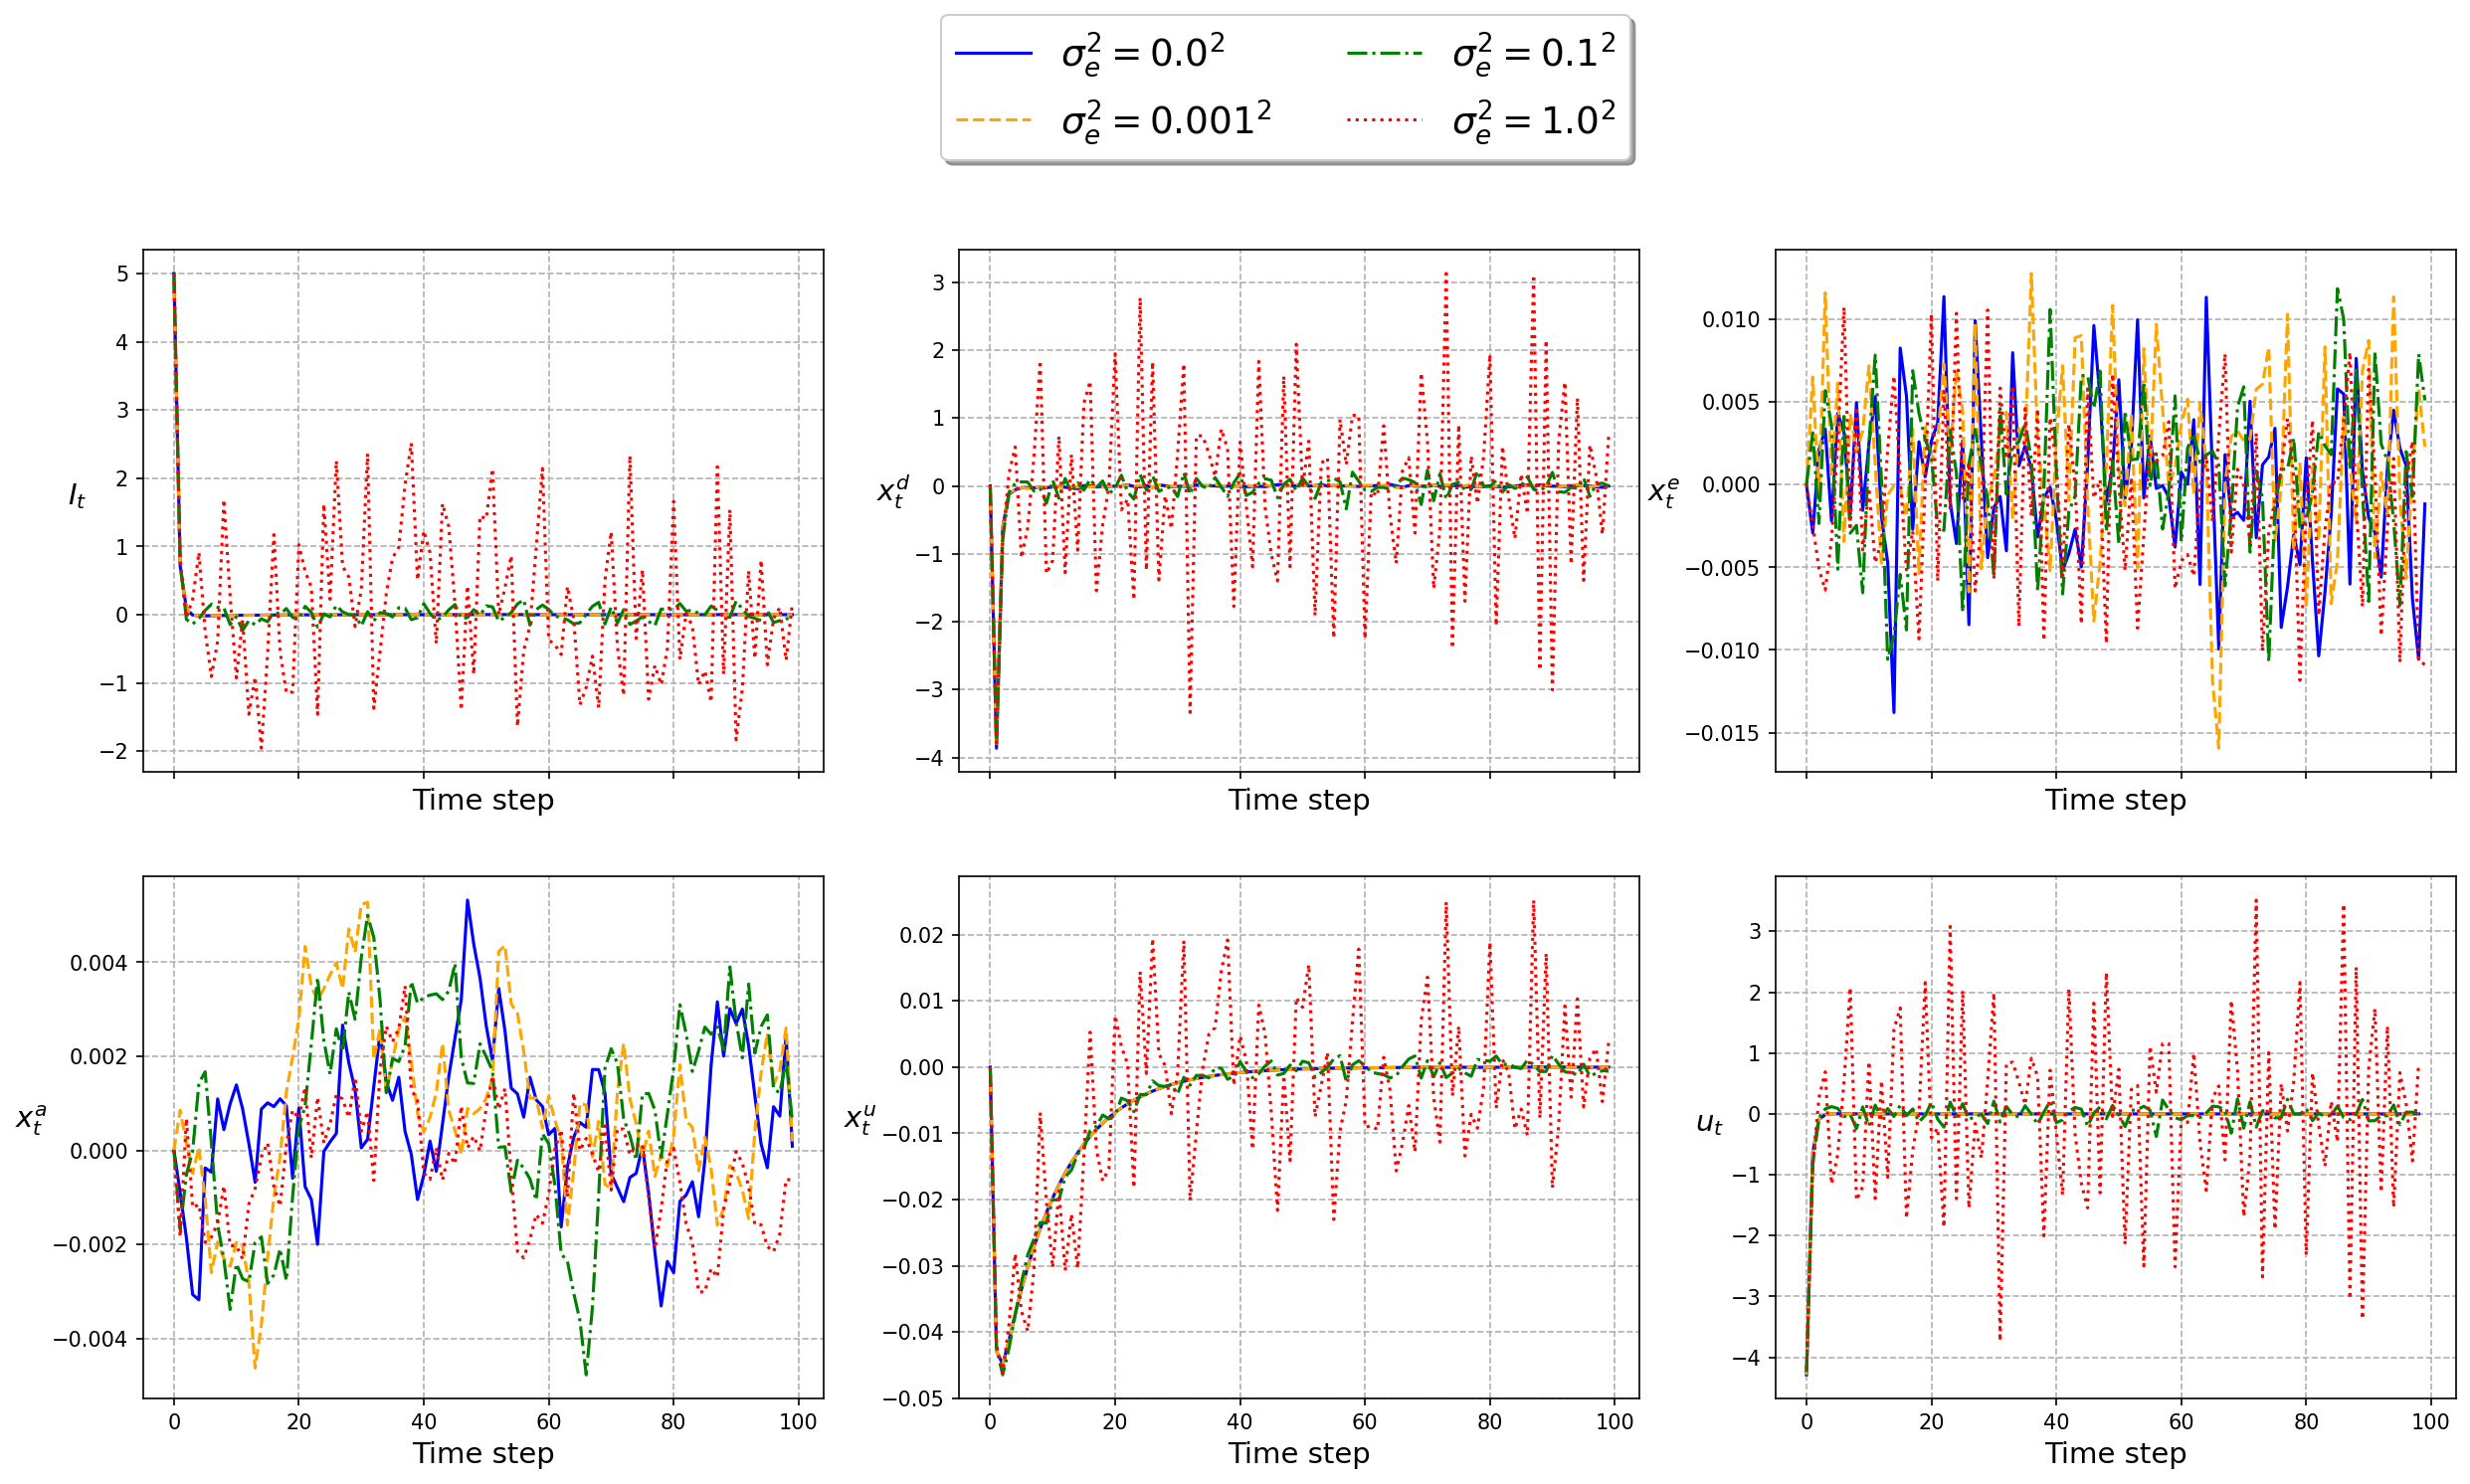

In [14]:
std_explo = [0.0, 1e-3, 0.1, 1.0]
dict_data_explo = {}
n_step = 100

for std in std_explo:
    data_explo = model.simulate_linear_model(x0_train, lambda x: phi_e(x, exploration_std=std), n_step = n_step, with_noise=True, std_const=0.1)

    dict_data_explo[fr"$\sigma_e^2 = {std}^2$"] = data_explo

utils.show_trajectories(dict_data_explo, save=SOURCE + "/trajectories_exploration.pdf")



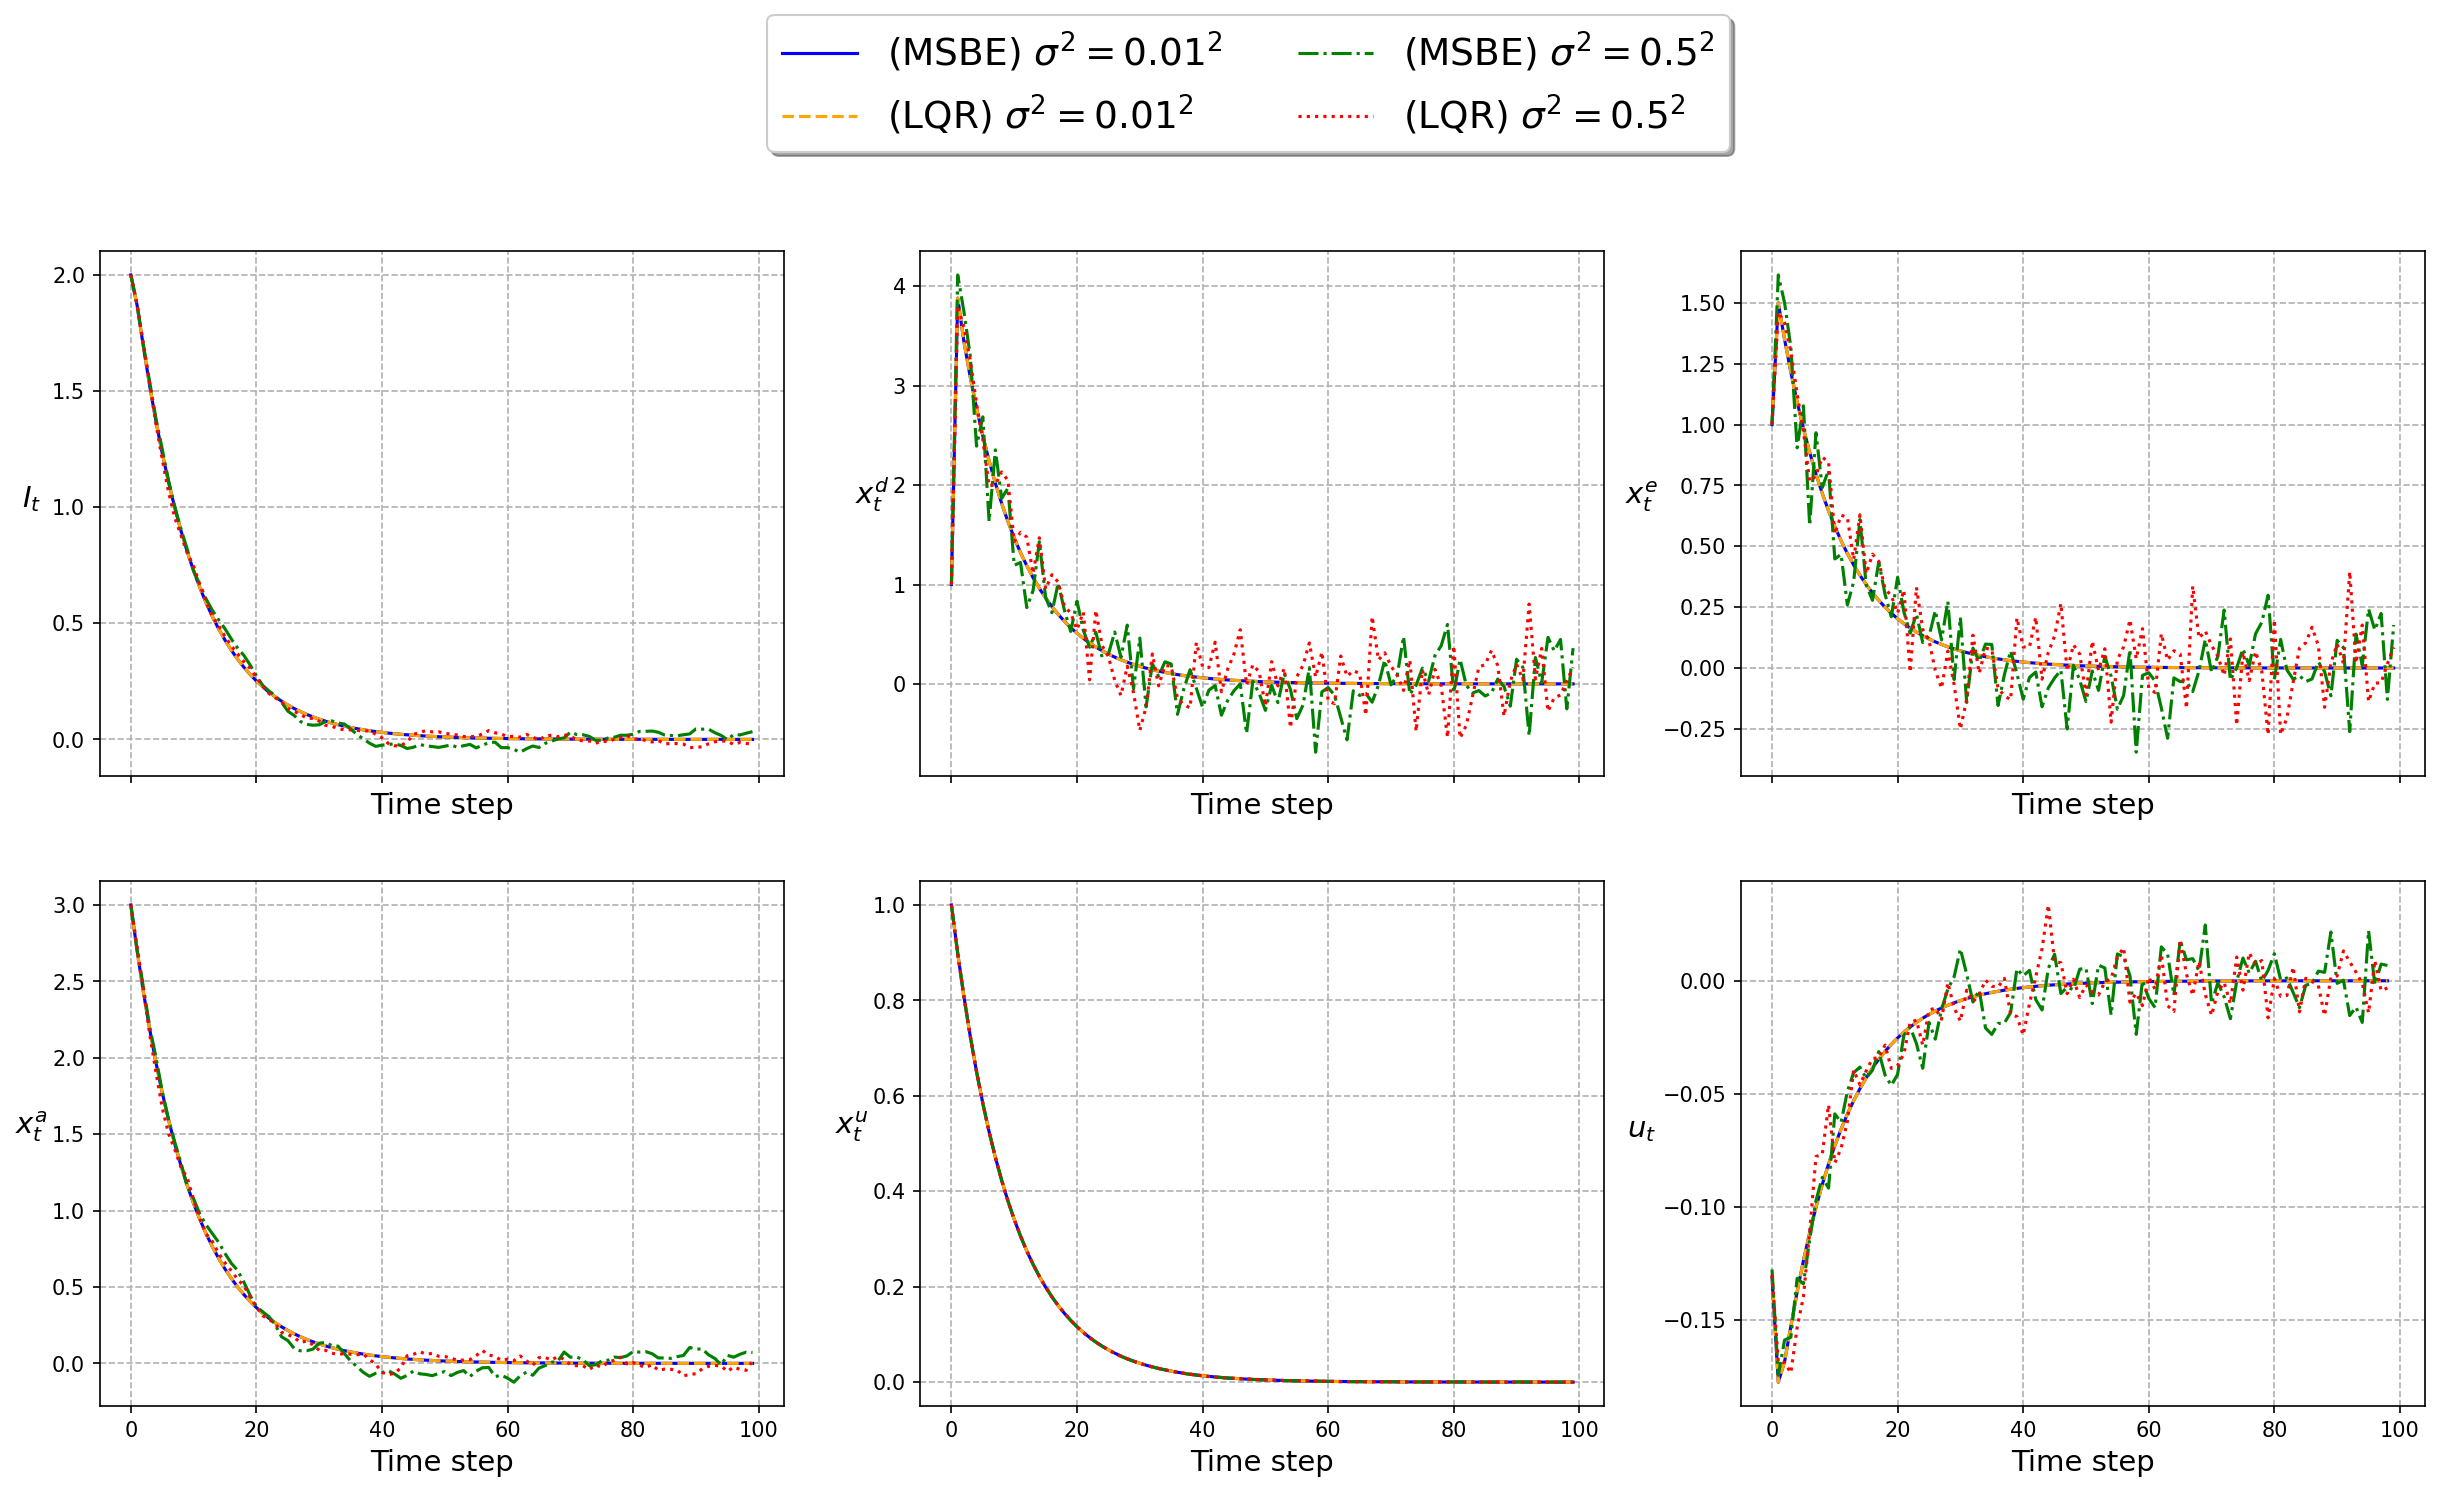

In [15]:
x0_train = [5, 0, 0, 0, 0]
n_step_train = 1000

x0_test = [2, 1, 1, 3, 1]
n_step_test = 100

exploration_std = 1e-1
n_noises = 20 # 20**2 combinations of noises
M = 10 

std_noises = [1e-2, .5]
dict_data_noise = {}
n_step = 100

for std in std_noises:
    transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
    data_train = model.simulate_linear_model(x0_train, policy_explo, n_step_train, with_noise=True, std_const=std)
    theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="lin")

    policy_MSBE = lambda x: policy_Q(x, theta = theta_MSBE)

    data_MSBE = model.simulate_linear_model(x0_test, policy_MSBE, n_step_test, with_noise=True, std_const=std)
    data_lqr  = model.simulate_linear_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=std)

    dict_data_noise[fr"(MSBE) $\sigma^2 = {std}^2$"] = data_MSBE
    dict_data_noise[fr"(LQR) $\sigma^2 = {std}^2$"] = data_lqr




utils.show_trajectories(dict_data_noise, save=SOURCE + "/linear_trajectories_comparisons.pdf")


## b. Non Linear Model : Approximation of the LQR Q-function

We define $\psi_Q$ and $\psi_\eta$

In [18]:
def psi_Q(x, u):

    if not np.isscalar(u):
        u = u[0]
        
    x1 = x[0]
    x4 = x[3]
    x5 = x[4]
    psi = [x1**2, x4**2, x5**2, u**2, x1*u, x4*u, x5*u,\
             x1*x4, x1*x5, x4*x5]

    return np.array(psi)

psi_eta = np.ones(10)

We first investigate the impact of the process noise 

In [19]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 1000
exploration_std = 1e-2
M = 10


n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]
cost_noises = {}

for noise_std in noises_std:

    cost_lqr_test, cost_msbe_test, cost_lstd_test = [], [], []

    for _ in range(M):
        # Simulate data

        policy_explo = lambda x: phi_e(x, exploration_std=exploration_std)
        data_train = model.simulate_nl_model(x0_train, policy_explo, n_step=n_step, with_noise=True, std_const=noise_std)
        data_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE

        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=2)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="nonlin", treshold_iter=200)
        theta_LSTD = lstd.perform_lstd(model.LQR_policy, model.cost, psi_Q, np.eye(10), data_train, d = 10)


        Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)
        Q_LSTD = lambda x, u : model.Q_function(x, u, theta = theta_LSTD, psi_func = psi_Q)
        
        def policy_MSBE(x):
            res = minimize(lambda u : Q_MSBE(x, u), 1)
            return res.x
        
        def policy_LSTD(x):
            res = minimize(lambda u : Q_LSTD(x, u), 1)
            return res.x
        
    
        cost_lqr_test.append(np.mean([model.cost(x, u) for x, u in zip(data_test[0].T, data_test[1].T)]))

        data_msbe = model.simulate_nl_model(x0_test, policy_MSBE, n_step=n_step, with_noise=True, std_const=noise_std)
        cost_msbe_test.append(np.mean([model.cost(x, policy_MSBE(x)) for x, _ in zip(data_msbe[0].T, data_msbe[1].T)]))

        data_lstd = model.simulate_nl_model(x0_test, policy_LSTD, n_step=n_step, with_noise=True, std_const=noise_std)
        cost_lstd_test.append(np.mean([model.cost(x, policy_LSTD(x)) for x, _ in zip(data_lstd[0].T, data_lstd[1].T)]))
                              

    cost_noises[noise_std] = {
            "cost_lqr_test" : np.mean(cost_lqr_test),
            "cost_MSBE_test" : np.mean(cost_msbe_test),
            "cost_LSTD_test" : np.mean(cost_lstd_test), 
    }
    

In [20]:
from tabulate import tabulate

# # Extract the data
noise_stds = list(cost_noises.keys())
cost_lqr_test = [cost_noises[std]["cost_lqr_test"] for std in noise_stds]
cost_MSBE_test = [cost_noises[std]["cost_MSBE_test"] for std in noise_stds]
cost_LSTD_test = [cost_noises[std]["cost_LSTD_test"] for std in noise_stds]

table_data = []
for std, lqr, msbe, lstd in zip(noise_stds, cost_lqr_test, cost_MSBE_test, cost_LSTD_test):
    table_data.append([
        f"$\\sigma^2 = {std}^2$",  # Use double backslashes for LaTeX math formatting
        f"{lqr:.2e}",            # Scientific notation for numbers
        f"{msbe:.2e}",
        f"{lstd:.2e}"
    ])

# Define the table headers
headers = ["Noise Std Dev", "Average Cost LQR", "Average Cost MSBE", "Average Cost LSTD"]

# Generate the LaTeX table
latex_table = tabulate(table_data, headers,tablefmt="latex_raw")

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lrrr}
\hline
 Noise Std Dev         &   Average Cost LQR &   Average Cost MSBE &   Average Cost LSTD \\
\hline
 $\sigma^2 = 0.0001^2$ &            -0.0196 &             -0.0182 &            2.35e+16 \\
 $\sigma^2 = 0.1^2$    &            -0.0197 &             -0.0197 &            2.48e+16 \\
 $\sigma^2 = 0.5^2$    &            -0.0223 &             -0.0224 &            2.51e+16 \\
 $\sigma^2 = 1^2$      &            -0.0323 &             -0.0301 &            2.85e+16 \\
 $\sigma^2 = 2^2$      &            -0.0657 &             -0.0653 &            2.3e+16  \\
\hline
\end{tabular}


We now investigate the impact of the exploration policy only for MSBE 

In [ ]:
x0_train = [5, 0, 0, 0, 0]
x0_test = [2, 1, 1, 3, 1]
n_step = 100
M = 10

n_noises = 20 # 20**2 combinations of noises
noise_std = 0.1

cost_explo = {}
noises_explo = [0.0, 1e-6, 1e-3, 0.1, 1.0, 2]

for noise_explo in noises_explo:
    cost_lqr_test, cost_msbe_test = [], [], 

    for _ in range(M):  # Perform M simulations

        # Simulate data
        data_lqr_test = model.simulate_nl_model(x0_test, model.LQR_policy, n_step=n_step, with_noise=True, std_const=noise_std)
        policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)
        data_train = model.simulate_nl_model(x0_train, policy_explo, n_step, with_noise=True, std_const=noise_std)

        # Compute MSBE
        
        transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
        theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="nonlin", treshold_iter=200)

        Q_MSBE = lambda x, u : model.Q_function(x, u, theta = theta_MSBE, psi_func = psi_Q)
        
        
        def policy_MSBE(x):
            res = minimize(lambda u : Q_MSBE(x, u), 1)
            return res.x
        
        
        cost_msbe_test.append(np.average(np.array([model.cost(x, policy_MSBE(x)) for x, _ in zip(data_test[0].T, data_test[1].T)]).squeeze()))
        cost_lqr_test.append(np.average(np.array([model.cost(x, model.LQR_policy(x)) for x, _ in zip(data_test[0].T, data_test[1].T)]).squeeze()))

                             
    cost_explo[noise_explo] = {
           "cost_LQR_test" : np.mean(cost_lqr_test),
            "cost_MSBE_test" : np.mean(cost_msbe_test),
}  
    


In [22]:
# Extract the data
noise_stds = list(cost_explo.keys())
cost_LQR_test = [cost_explo[std]["cost_LQR_test"] for std in noise_stds]
cost_MSBE_test = [cost_explo[std]["cost_MSBE_test"] for std in noise_stds]


table_data = []
for std, lqr, msbe in zip(noise_stds, cost_lqr_test, cost_MSBE_test):
    table_data.append([
        f"$\\sigma^2 = {std}^2$",  # Use double backslashes for LaTeX math formatting
        f"{lqr:.2e}",            # Scientific notation for numbers
        f"{msbe:.2e}",
    ])

# Define the table headers
headers = ["Noise Std Dev", "Average Cost LQR", "Average Cost MSBE"]

# Generate the LaTeX table
latex_table = tabulate(table_data, headers,tablefmt="latex_raw")

# Print the LaTeX table
print(latex_table)


\begin{tabular}{lrr}
\hline
 Noise Std Dev        &   Average Cost LQR &   Average Cost MSBE \\
\hline
 $\sigma^2 = 0.0^2$   &            -0.0496 &            0.000914 \\
 $\sigma^2 = 1e-06^2$ &            -0.0496 &            0.00269  \\
 $\sigma^2 = 0.001^2$ &            -0.0496 &           -0.0498   \\
 $\sigma^2 = 0.1^2$   &            -0.0496 &           -0.0495   \\
 $\sigma^2 = 1.0^2$   &            -0.0496 &           -0.0497   \\
 $\sigma^2 = 2^2$     &            -0.0496 &           -0.0498   \\
\hline
\end{tabular}


We now look at some trajectories 

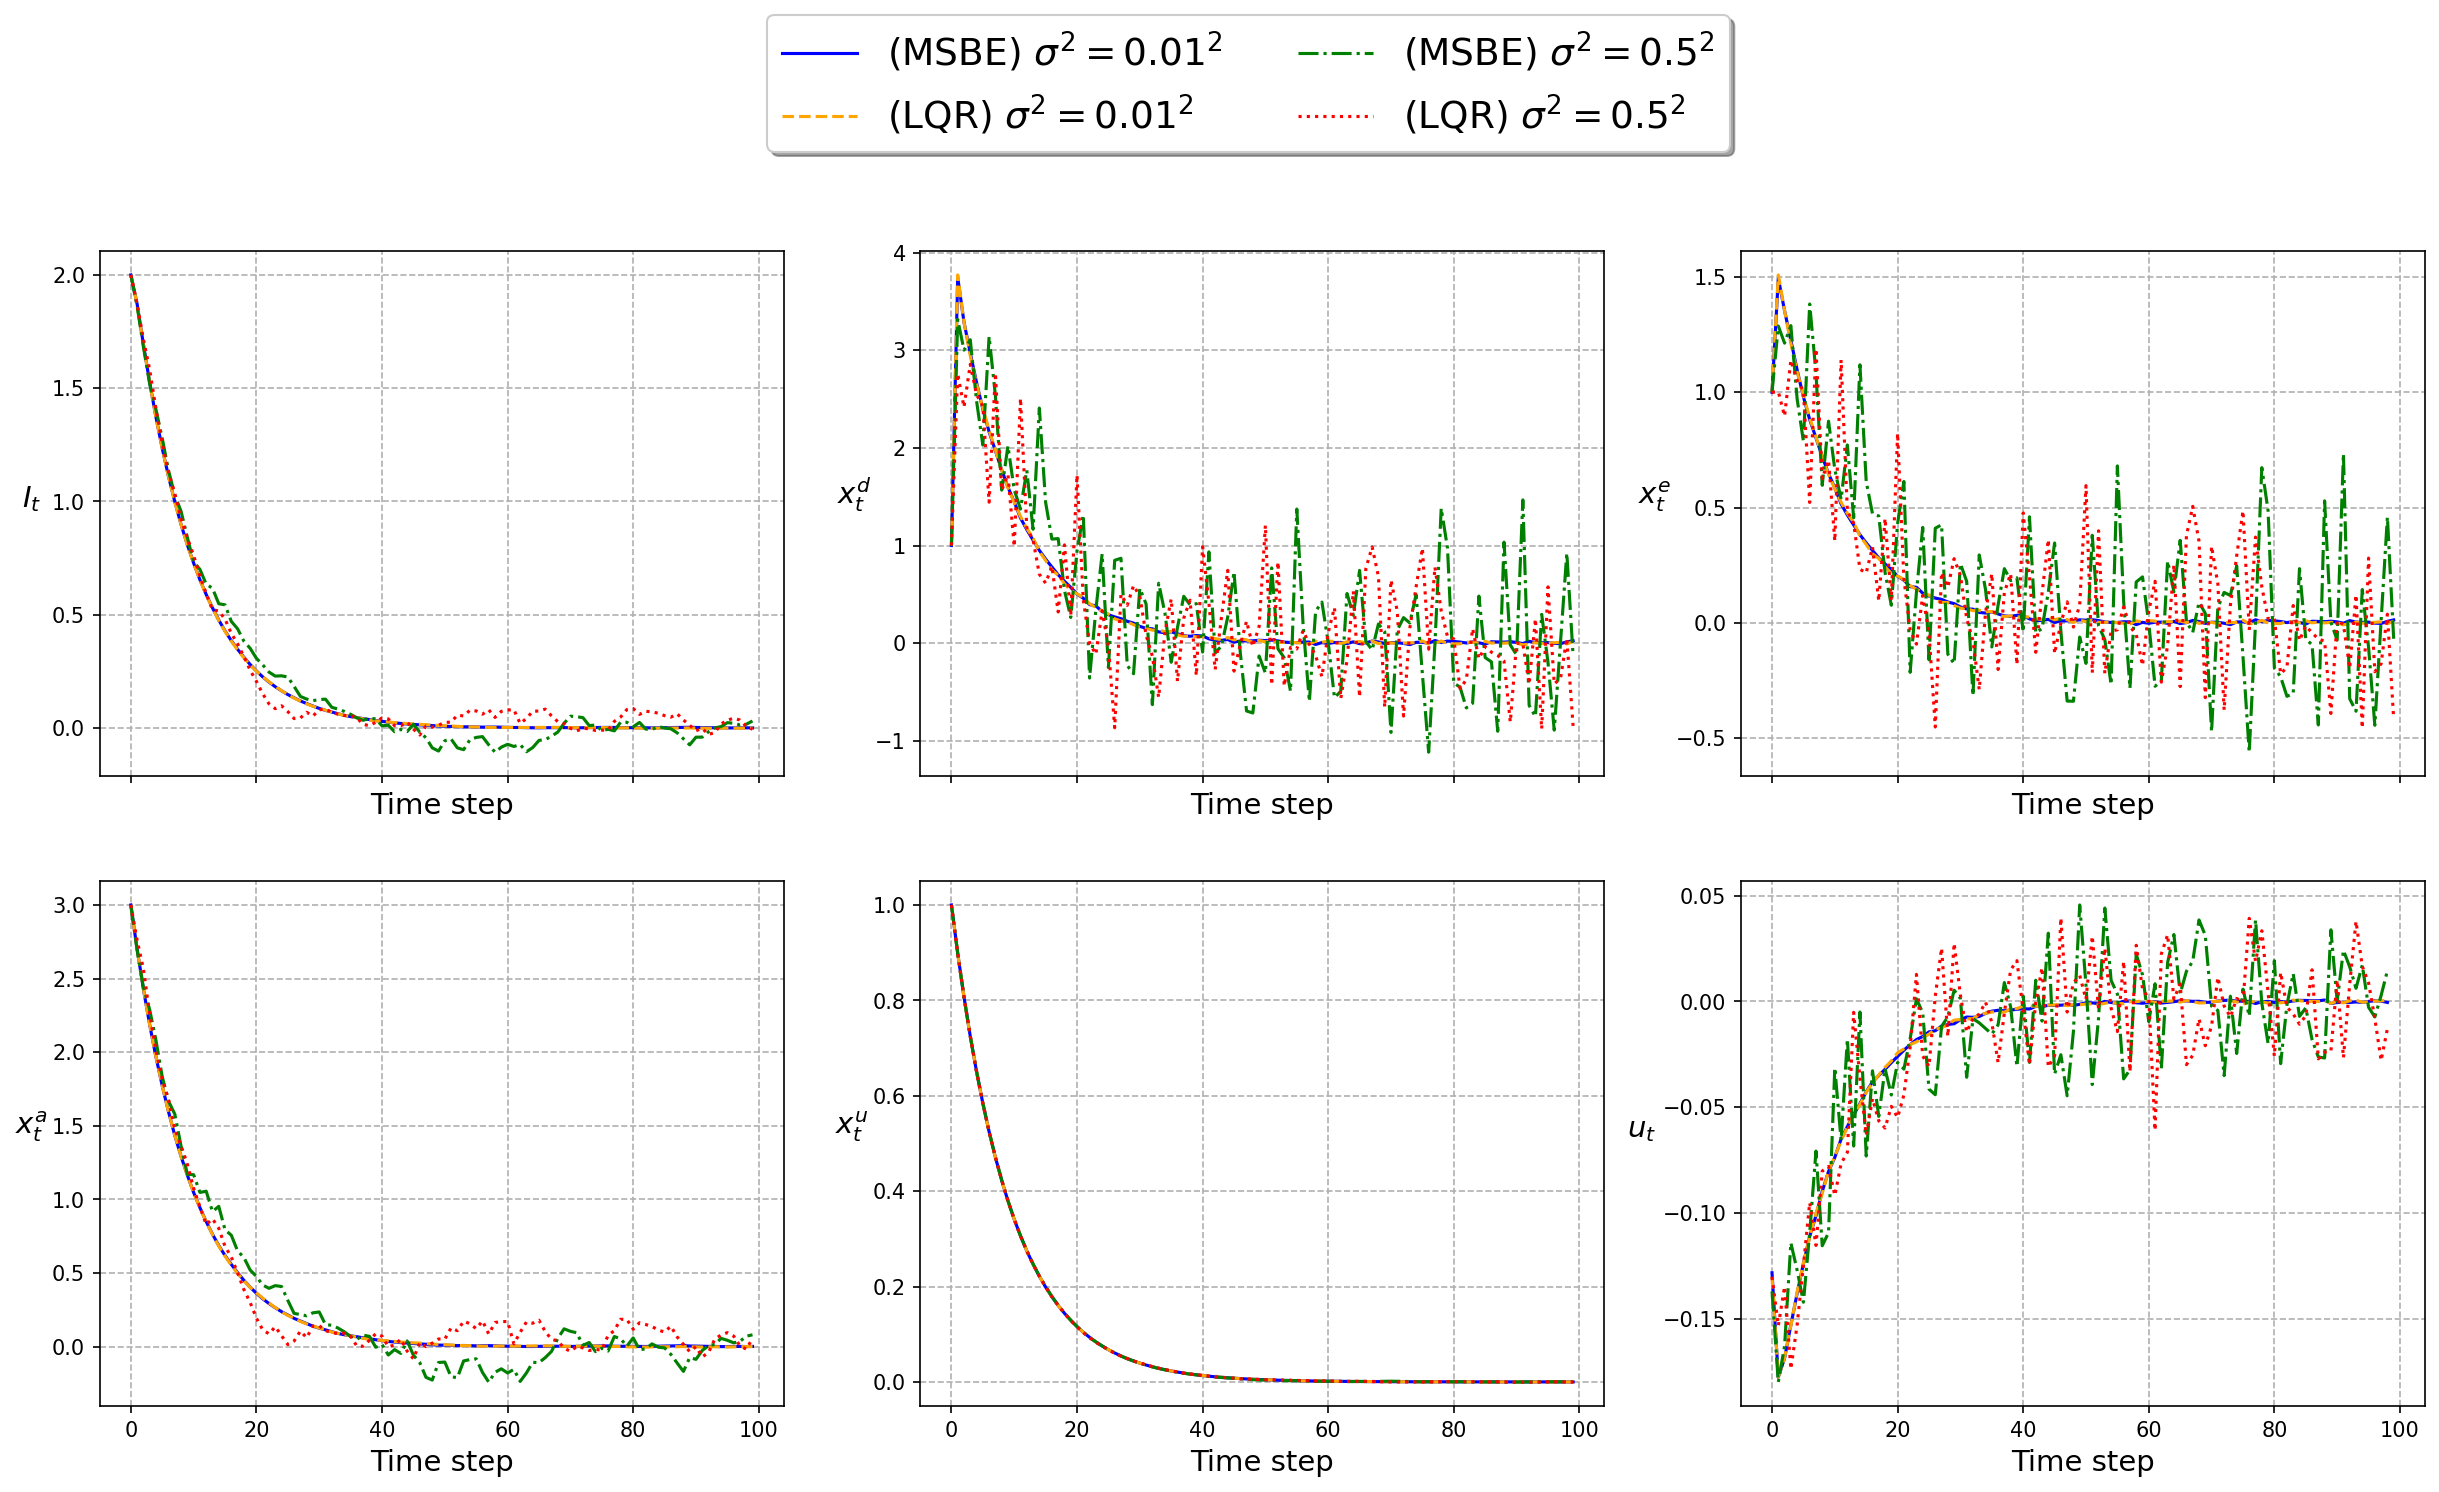

In [ ]:
x0_train = [5, 0, 0, 0, 0]
n_step_train = 1000

x0_test = [2, 1, 1, 3, 1]
n_step_test = 100

exploration_std = 1e-1
n_noises = 20 # 20**2 combinations of noises


std_noises = [1e-2, .5]
dict_data_noise = {}
n_step = 100

for std in std_noises:
    transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
    data_train = model.simulate_nl_model(x0_train, policy_explo, n_step_train, with_noise=True, std_const=std)
    theta_MSBE = compute_MSBE(data_train, transition_kernel, psi_Q, psi_eta, model_str="nonlin", treshold_iter=200)

    policy_MSBE = lambda x: policy_Q(x, theta = theta_MSBE)

    data_MSBE = model.simulate_nl_model(x0_test, policy_MSBE, n_step_test, with_noise=True, std_const=std)
    data_lqr  = model.simulate_nl_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=std)

    dict_data_noise[fr"(MSBE) $\sigma^2 = {std}^2$"] = data_MSBE
    dict_data_noise[fr"(LQR) $\sigma^2 = {std}^2$"] = data_lqr




utils.show_trajectories(dict_data_noise, save=SOURCE + "/non_linear_trajectories_comparisons.pdf")


### c. Policy Improvement 

#### Linear Model with another policy than LQR as inital policy

In [ ]:
import tqdm
x0_train = [5, 0, 0, 0, 0]
n_step_train = 1000
x0_test = [2, 1, 1, 3, 1]
n_step_test = 100
M = 1

n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]


noise_explo = 1e-1
policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)

def init_policy(x):
    return np.zeros(1)

cost_PI, cost_lqr = {}, {}

for noise_std in tqdm.tqdm(noises_std, total=len(noises_std)):

    transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
    data_train = model.simulate_linear_model(x0_train, policy_explo, n_step_train, with_noise=True, std_const=noise_std)

    theta_MSBE = policy_improvement_MSBE(init_policy, psi_Q, psi_eta, transition_kernel, data_train, model_str="lin", max_iter=100, treshold_iter=200)
    policy_MSBE = lambda x: policy_Q(x, theta = theta_MSBE)

    data_msbe = model.simulate_linear_model(x0_test, policy_MSBE, n_step_test, with_noise=True, std_const=noise_std)
    data_lqr = model.simulate_linear_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=noise_std)


    cost_PI[rf"$\sigma^2 = {noise_std}^2$"] = np.mean([model.cost(x, policy_MSBE(x)) for x in data_msbe[0].T])
    cost_lqr[rf"$\sigma^2 = {noise_std}^2$"] = np.mean([model.cost(x, model.LQR_policy(x)) for x in data_lqr[0].T])
    
print(cost_PI,
      cost_lqr)


100%|██████████| 10/10 [00:33<00:00,  3.33s/it]


In [ ]:
n_step_train = 1000
x0_train = [5, 0, 0, 0, 0]
n_step_test = 100
x0_test = [2, 1, 1, 3, 1]


std_noises = [1e-2, .5]
dict_data = {}

for std_noise in std_noises:

    data_train = model.simulate_linear_model(x0_train, lambda x: phi_e(x, exploration_std=1e-1), n_step_train, with_noise=True, std_const=std_noise)
    transition_kernel = generate_finite_kernel(n_noises=20, noise_std=std_noise, k=1)


    theta_MSBE_PI = policy_improvement_MSBE(lambda x : np.ones_like(x), psi_Q, psi_eta, transition_kernel, data_train, model_str="lin", max_iter=10, treshold_iter= 200)
    policy_MSBE_PI = lambda x: policy_Q(x, theta = theta_MSBE_PI)


    dict_data[f"(PI MSBE) $\sigma^2 = {std_noise}^2$"] = model.simulate_linear_model(x0_test, policy_MSBE_PI, n_step_test, with_noise=True,  std_const=std_noise)
    dict_data[f"(LQR) $\sigma^2 = {std_noise}^2$"] = model.simulate_linear_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=std_noise)


utils.show_trajectories(dict_data, save = SOURCE + "/linear_trajectories_PI.pdf")

#### Non Linear Model with LQR as initial policy

In [ ]:
import tqdm
x0_train = [5, 0, 0, 0, 0]
n_step_train = 1000
x0_test = [2, 1, 1, 3, 1]
n_step_test = 100
M = 1

n_noises = 20 # 20**2 combinations of noises
noises_std = [1e-4, 0.1, 0.5, 1, 2]


noise_explo = 1e-2
policy_explo = lambda x: phi_e(x, exploration_std=noise_explo)

def init_policy(x):
    return np.zeros(1)

cost_nonlin_PI, cost_nonlin_lqr = {}, {}

for noise_std in tqdm.tqdm(noises_std, total=len(noises_std)):

    transition_kernel = generate_finite_kernel(n_noises=n_noises, noise_std=noise_std, k=1)
    data_train = model.simulate_nl_model(x0_train, policy_explo, n_step_train, with_noise=True, std_const=noise_std)

    theta_MSBE = policy_improvement_MSBE(init_policy, psi_Q, psi_eta, transition_kernel, data_train, model_str="nonlin", max_iter=100, treshold_iter=200)
    policy_MSBE = lambda x: policy_Q(x, theta = theta_MSBE)

    data_msbe = model.simulate_nl_model(x0_test, policy_MSBE, n_step_test, with_noise=True, std_const=noise_std)
    data_lqr = model.simulate_nl_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=noise_std)


    cost_nonlin_PI[rf"$\sigma^2 = {noise_std}^2$"] = np.mean([model.cost(x, policy_MSBE(x)) for x in data_msbe[0].T])
    cost_nonlin_lqr[rf"$\sigma^2 = {noise_std}^2$"] = np.mean([model.cost(x, model.LQR_policy(x)) for x in data_lqr[0].T])
    
print(cost_nonlin_PI,
      cost_nonlin_lqr)


100%|██████████| 10/10 [06:00<00:00, 36.02s/it]


In [ ]:
print(cost_nonlin_PI)

{'cost_PI_test': 30.394661874467317, 'cost_lqr_test': -0.19633592471687475}


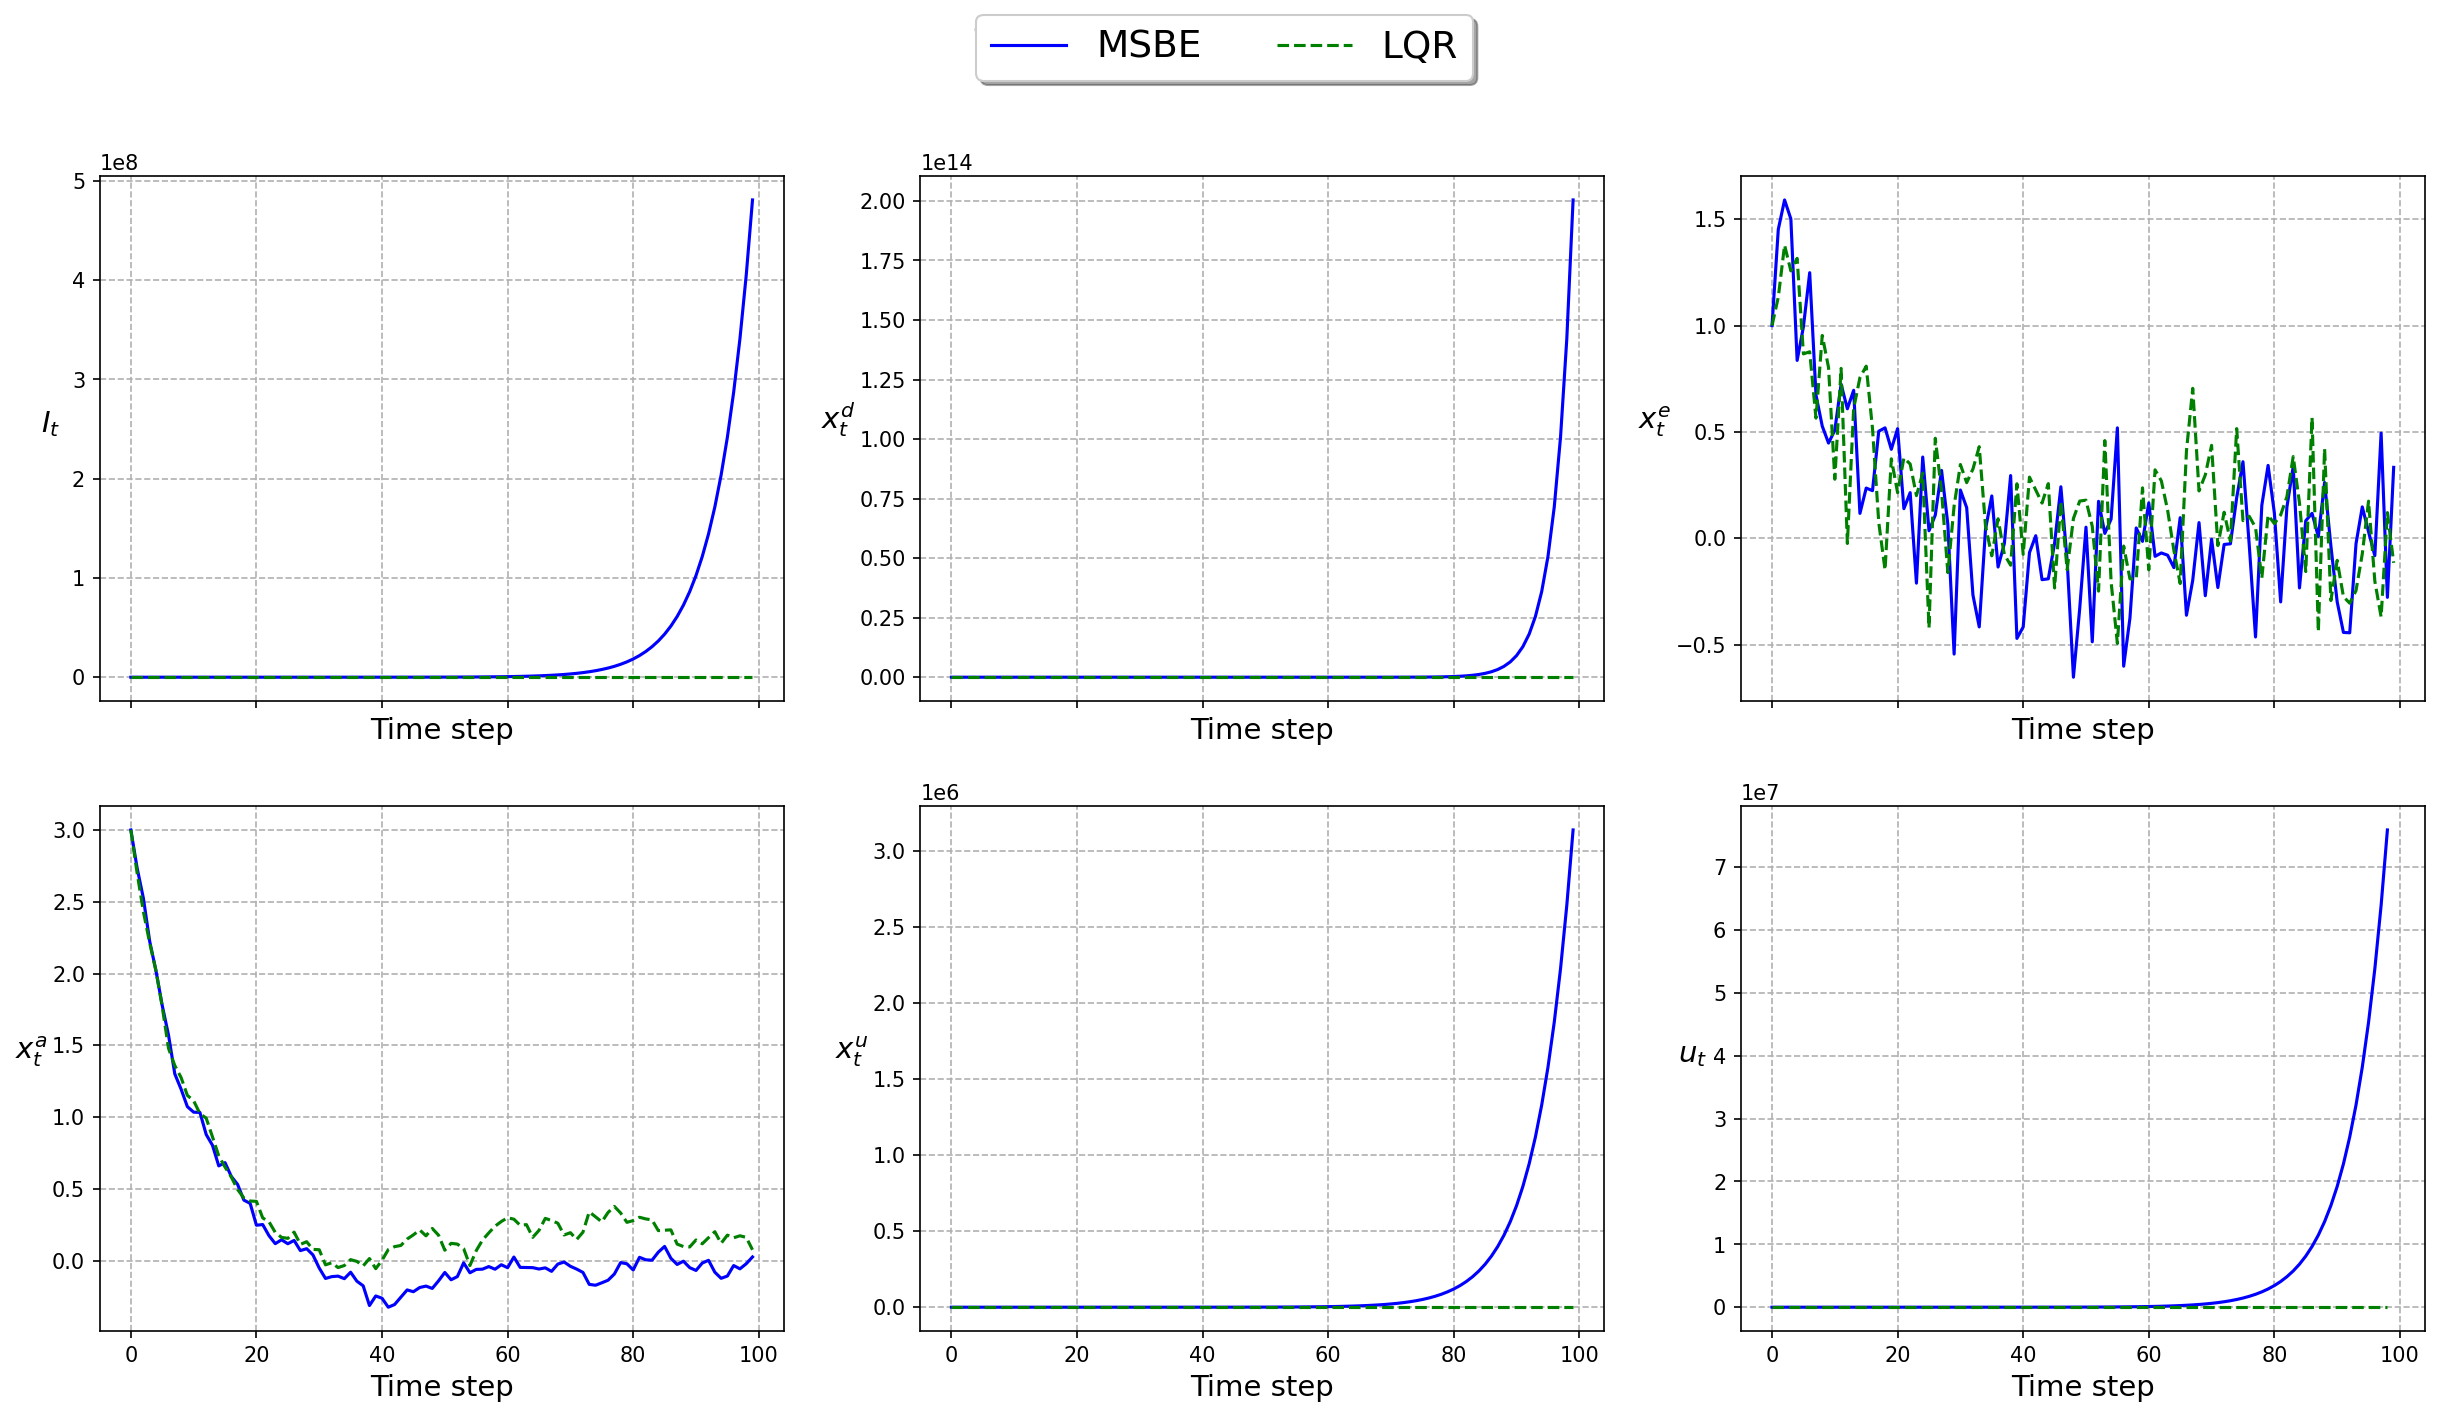

In [ ]:
n_step_train = 1000
x0_train = [5, 0, 0, 0, 0]
n_step_test = 100
x0_test = [2, 1, 1, 3, 1]


std_noises = [1e-4, 1e-2]
dict_data = {}

for std_noise in std_noises:

    data_train = model.simulate_nl_model(x0_train, lambda x: phi_e(x, exploration_std=1e-2), n_step_train, with_noise=True, std_const=std_noise)
    transition_kernel = generate_finite_kernel(n_noises=20, noise_std=std_noise, k=1)


    theta_MSBE_PI = policy_improvement_MSBE(model.LQR_policy, psi_Q, psi_eta, transition_kernel, data_train, model_str="nonlin", max_iter=100, treshold_iter= 200)
    policy_MSBE_PI = lambda x: policy_Q(x, theta = theta_MSBE_PI)


    dict_data[f"(PI MSBE) $\sigma^2 = {std_noise}^2$"] = model.simulate_nl_model(x0_test, policy_MSBE_PI, n_step_test, with_noise=True,  std_const=std_noise)
    dict_data[f"(LQR) $\sigma^2 = {std_noise}^2$"] = model.simulate_nl_model(x0_test, model.LQR_policy, n_step_test, with_noise=True, std_const=std_noise)


utils.show_trajectories(dict_data, save = SOURCE + "/linear_trajectories_PI.pdf")